# 探索性数据分析

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import font_manager
from matplotlib import rcParams

# 字体加载
font_path = ('Times_SimSun.ttf') #字体路径
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# 字体设置
rcParams['font.family'] = 'sans-serif' # 使用字体中的无衬线体
rcParams['font.sans-serif'] = prop.get_name()  # 根据名称设置字体
rcParams['axes.unicode_minus'] = False # 使坐标轴刻度标签正常显示正负号

In [2]:
df_label = pd.read_csv('data/weibo_label.csv')  # 全部的标注数据
df_origin = pd.read_csv('data/weibo_origin.csv')  # 自己的原始微博数据

# 读入合肥市及其区县的边界数据
district = gpd.read_file('shapefile/合肥市_区县.shp')
city = gpd.read_file('shapefile/合肥市.shp')

Text(0.5, 1.0, '安徽省合肥市')

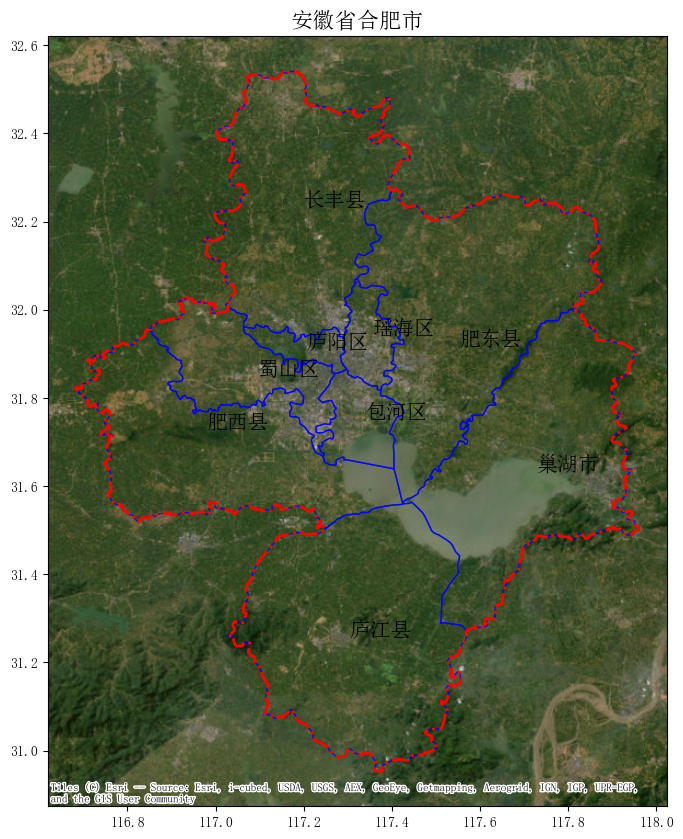

In [3]:
fig, ax = plt.subplots(1,figsize=(16, 10))
# 城市边界线
ax = city.boundary.plot(edgecolor='red', linewidth=2, linestyle='-.', alpha=1, ax=ax)
# 区县边界线
ax = district.plot(facecolor='none', edgecolor='blue', linewidth=1, linestyle='-', alpha=0.8, ax=ax)
cx.add_basemap(ax, crs=district.crs.to_string(), source=cx.providers.Esri.WorldImagery)

texts = []
for x, y, label in zip(district.representative_point().x, district.representative_point().y, district['NAME']):
    texts.append(plt.text(x, y, label, fontsize=15))

ax.set_title("安徽省合肥市", fontsize=16)

In [4]:
df_origin

,id,userid,message,ts_created
0,4817910549973967,6339251717,记录一下合肥一日游[送花花][送花花],2022-09-26 11:27:30
1,4817738155690682,6080243764,真诚才是爱的秘密,2022-09-26 00:02:28
2,4819531555412098,5867909333,回家[给力],2022-09-30 22:48:48
3,4818048550179045,3289196050,躺平大师,2022-09-26 20:35:52
4,4819813207117305,6495662753,终于[泪],2022-10-01 17:27:59
...,...,...,...,...
25989,4820530244883475,6219366090,热傻了今天,2022-10-03 16:57:14
25990,4821179631666949,6557015016,#挪威海底电缆断裂#北约除了干瞪眼！实在做不出别的事情 跟北溪二号一样 哑巴吃黄连，有苦...,2022-10-05 11:57:40
25991,4821641589163051,5639007389,今天：合肥下雨了，晚上加班到十点半 不过还好，心情不是很糟糕 我还是心心念念想要养一只小猫,2022-10-06 18:33:19
25992,4818771782408232,2072019043,参观晚清重臣李鸿章故居，重温那段风云变幻的历史，不胜感慨！“时来天地皆同力，运去英雄不自由”...,2022-09-28 20:29:44


In [5]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25994 entries, 0 to 25993
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          25994 non-null  int64 
 1   userid      25994 non-null  int64 
 2   message     25994 non-null  object
 3   ts_created  25994 non-null  object
dtypes: int64(2), object(2)
memory usage: 812.4+ KB


In [6]:
df_origin.nunique()

id            25994
userid        15604
message       24068
ts_created    25619
dtype: int64

## 时间特征

In [7]:
df_origin['ts_created'] = pd.to_datetime(df_origin['ts_created'])  # 数据格式转换
df_origin['date'] = pd.to_datetime(pd.to_datetime(df_origin['ts_created']).dt.date)  # 整合'date'只有年月日

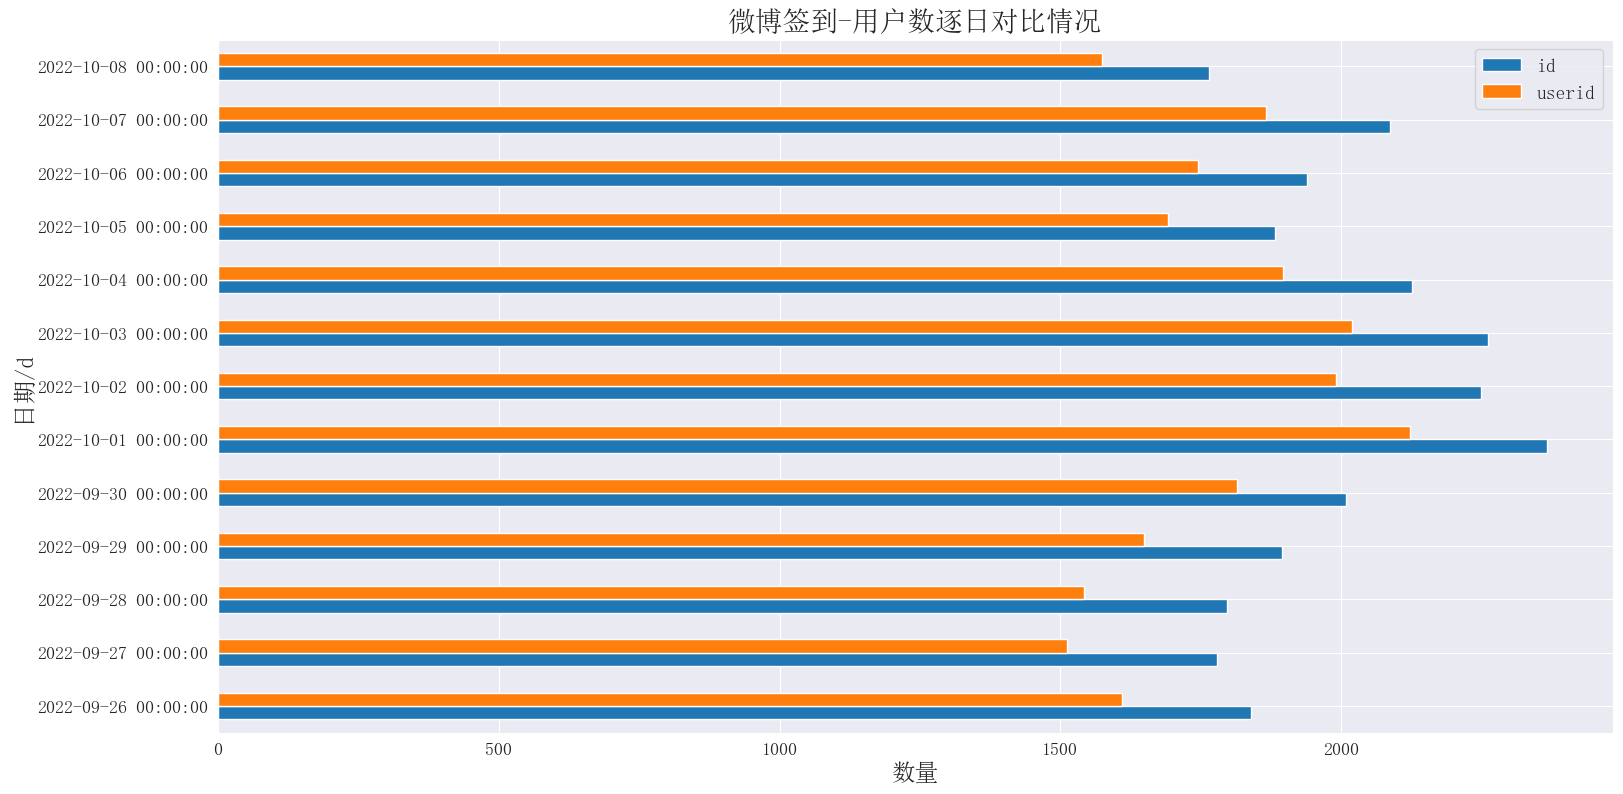

In [8]:
with sns.axes_style('darkgrid'):
    df_origin.set_index('date').groupby(by='date').agg({'id':'nunique','userid':'nunique'}).plot(kind='barh',figsize=(18,9))
    plt.xticks(size=13)
    plt.yticks(size=13)
    plt.xlabel('数量',size=17)
    plt.ylabel('日期/d',size=17)
    plt.legend(prop={'size':14})
    plt.title('微博签到-用户数逐日对比情况',size=20)

Text(0.5, 1.0, '日签到量')

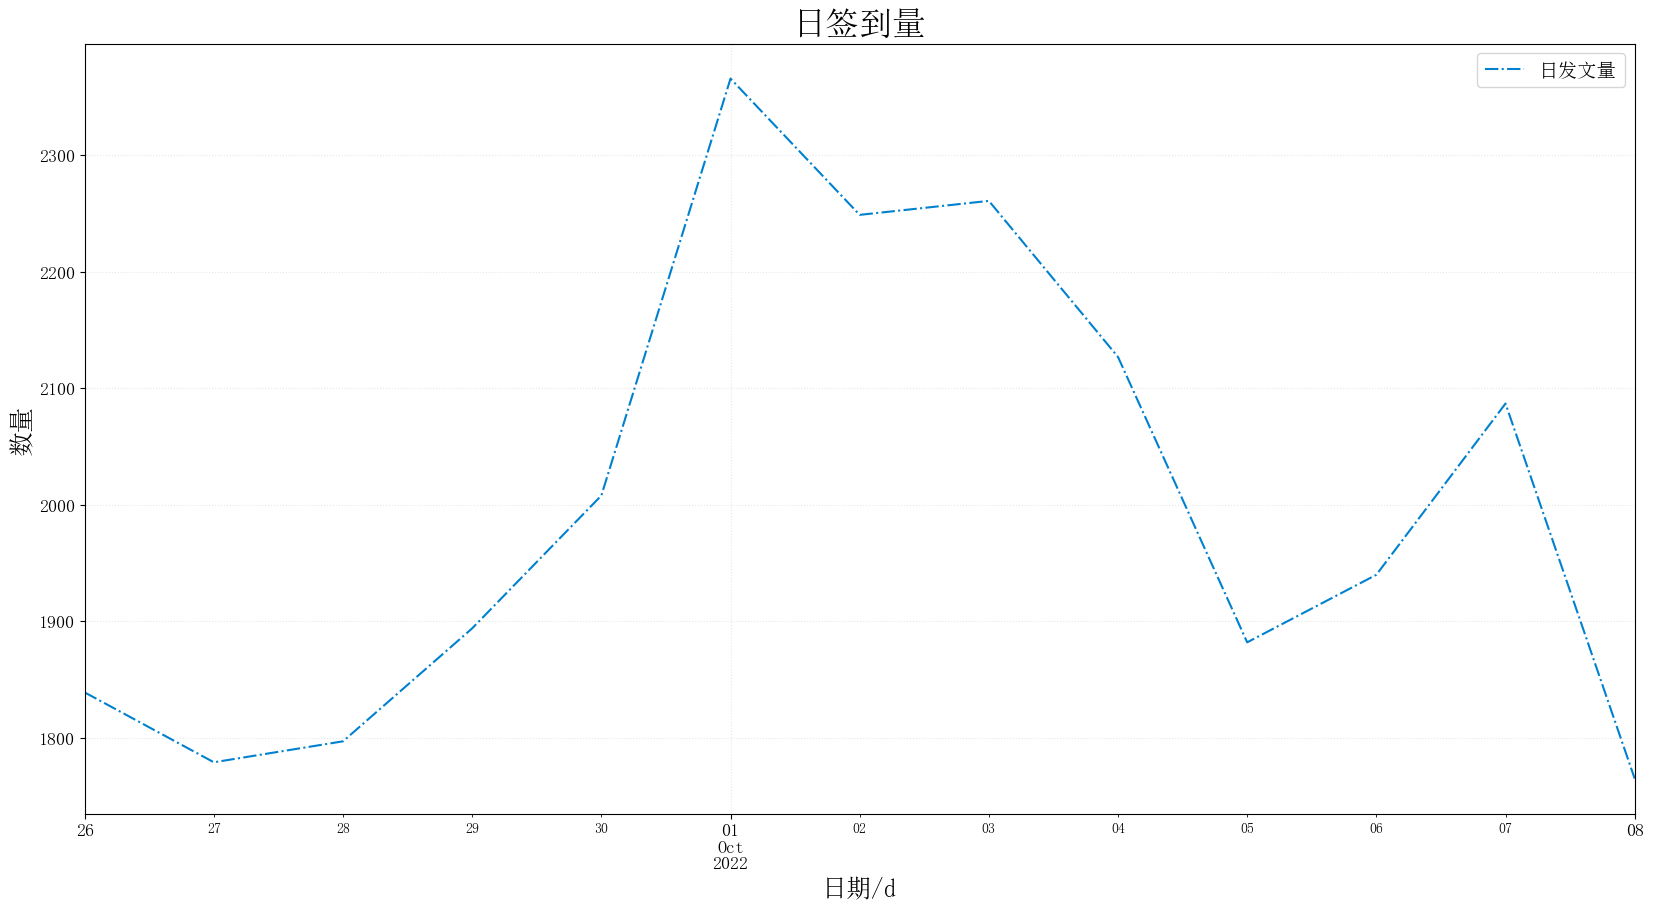

In [9]:
ax = df_origin.set_index('ts_created').resample('D')['id'].count().plot(ls='-.',label='日发文量',color='#0081CF',figsize=(20,10))
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('日期/d',size=18)
plt.ylabel('数量',size=18)
plt.grid(ls=':',alpha=0.3)
plt.legend(loc='best',prop={'size':14})
plt.title('日签到量',size=24)

* 可以看到9月27日开始，发文量逐日增加，到国庆节当天(10月1日)达到峰值
* 10月1日之后，发文量开始呈现递减趋势，直到10月5日达到谷底(国庆期间)
* 10月5日之后，发文量又开始递增，直到国庆节结束当天(10月7日)达到峰值

In [10]:
# 统计24小时,每小时发文量
df_hour = df_origin.set_index('ts_created').resample('H')['id'].count()
df_hour = df_hour.reset_index()
df_hour['hour'] = df_hour['ts_created'].dt.hour
df_hour['date'] = df_hour['ts_created'].dt.date

C:\Users\15499\AppData\Local\Temp\ipykernel_19928\2795704464.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df_origin.set_index('ts_created').resample('H')['id'].count()


Text(0.5, 1.0, '各时段签到量')

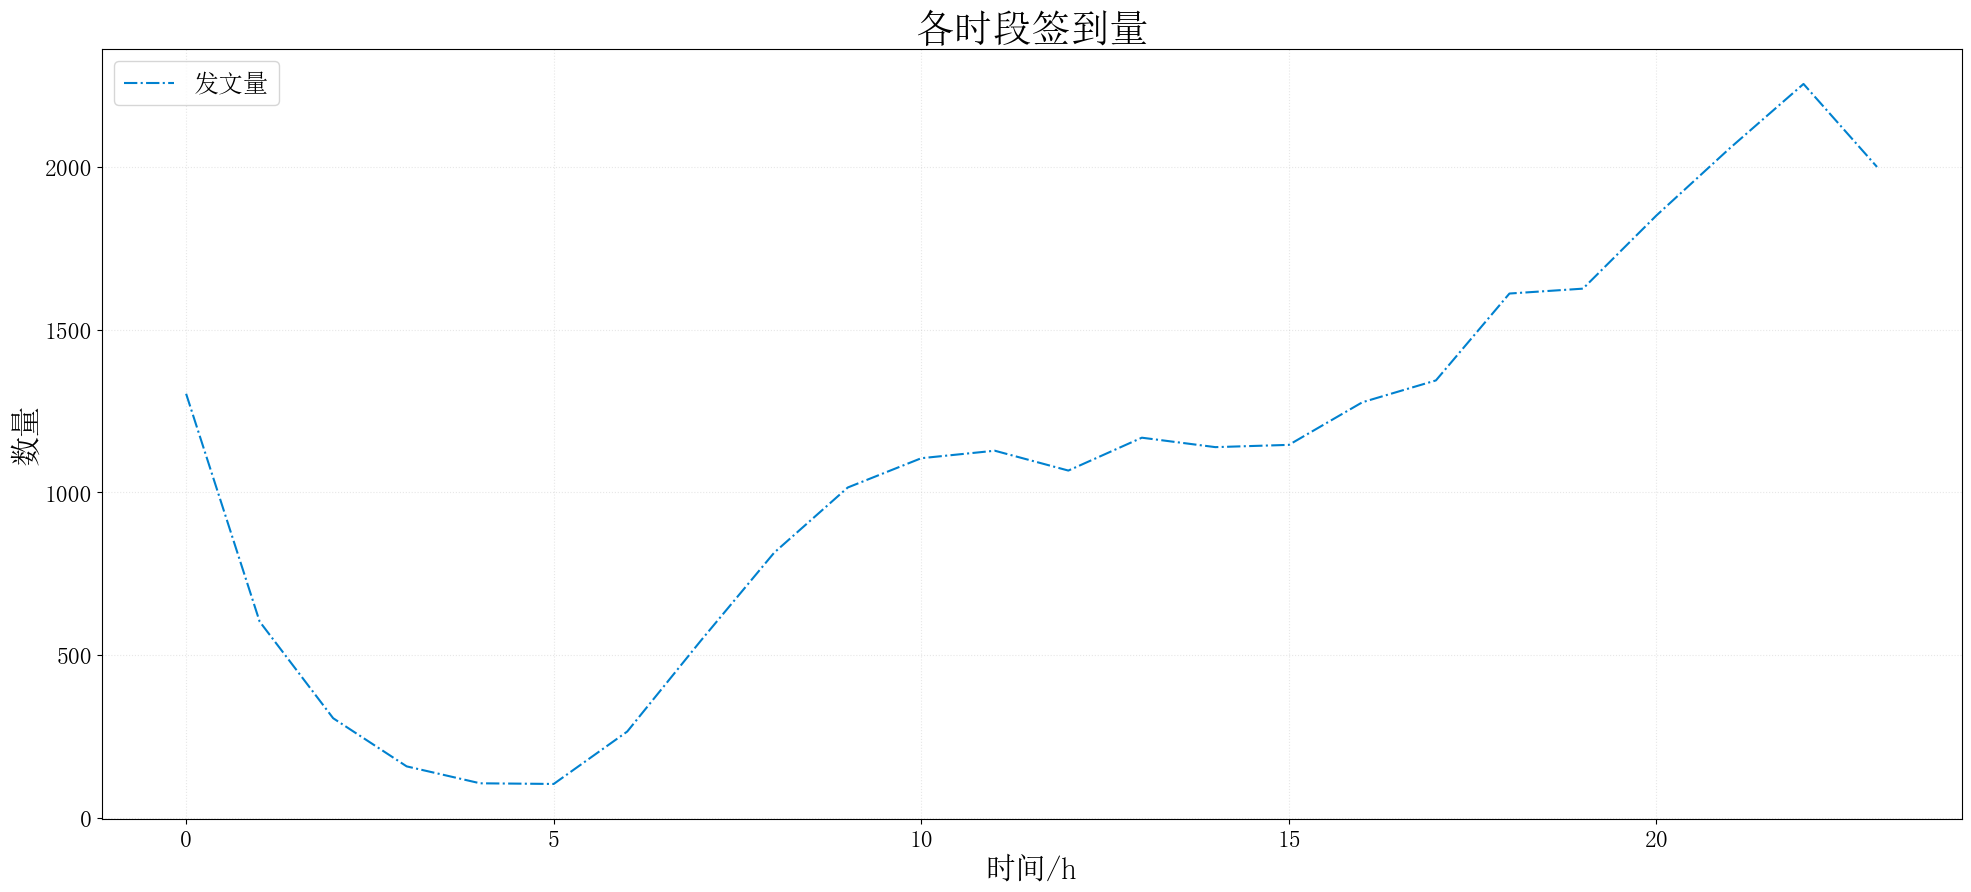

In [11]:
df_hour.groupby(by='hour')['id'].sum().plot(ls='-.',label='发文量',color='#0081CF',figsize=(24,10))
plt.xticks(size=17)
plt.yticks(size=17)
plt.xlabel('时间/h',size=22)
plt.ylabel('数量',size=22)
plt.grid(ls=':',alpha=0.3)
plt.legend(loc='best',prop={'size':18})
plt.title('各时段签到量',size=28)

* 发文主要集中在晚间19:00之后

In [12]:
df_hourTB = pd.crosstab(index=df_hour['date'],columns=df_hour['hour'],values=df_hour['id'],aggfunc='sum')
df_hourTB.dropna(inplace=True)
df_hourTB = df_hourTB.apply(pd.to_numeric,downcast='integer')
cmaps = sns.diverging_palette(240,10,n=9,as_cmap=True) # 红-白-蓝三色渐变
# df_hourTB.style.background_gradient()
df_hourTB.T

date,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,2022-10-01,2022-10-02,2022-10-03,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-08
hour,,,,,,,,,,,,,
0,109,73,63,94,92,138,120,127,122,86,93,89,97
1,35,24,35,37,36,60,83,63,58,44,36,48,44
2,14,17,10,24,23,21,29,31,26,20,29,36,26
3,15,7,4,13,10,13,17,15,15,9,17,15,8
4,3,8,6,5,8,6,14,13,14,9,5,5,10
5,4,6,7,11,5,17,8,10,14,5,8,4,5
6,20,22,15,19,27,54,25,22,18,9,8,11,15
7,47,47,36,49,53,68,47,39,31,34,27,29,37
8,73,56,65,96,67,68,73,45,61,54,42,47,68


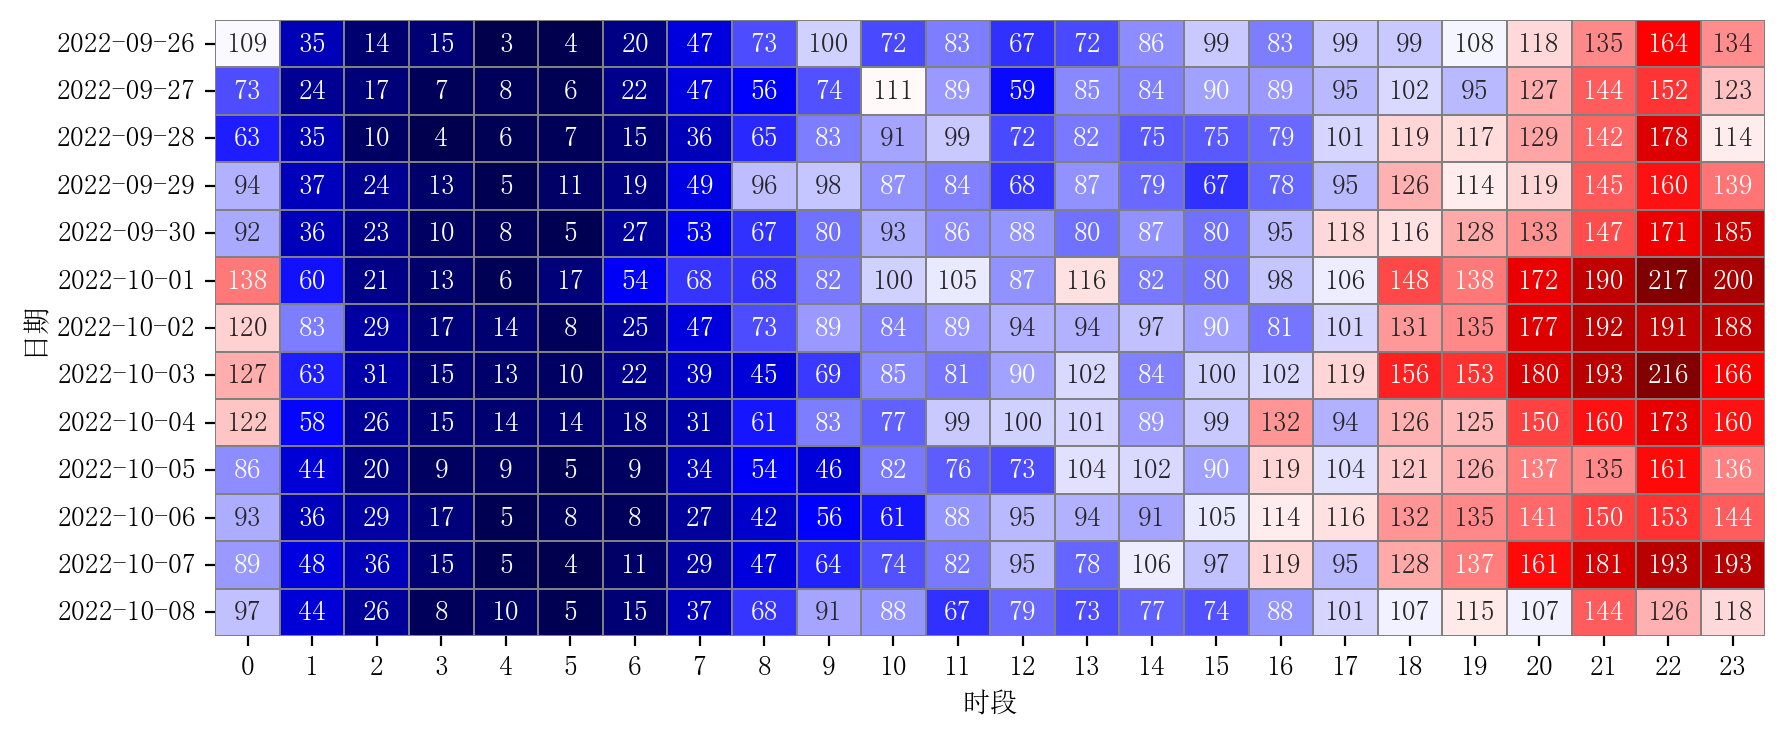

In [13]:
plt.figure(figsize=(10,4),dpi=200)
fig = sns.heatmap(df_hourTB,cmap='seismic', linecolor='grey', linewidths=0.1, cbar=False, annot=True, fmt=".0f")
plt.ylabel('日期')  # y轴label的文本和字体大小
plt.xlabel('时段')  # y轴label的文本和字体大小
figure = fig.get_figure()
figure.savefig('fig/热力图1.png',dpi=200,bbox_inches='tight')

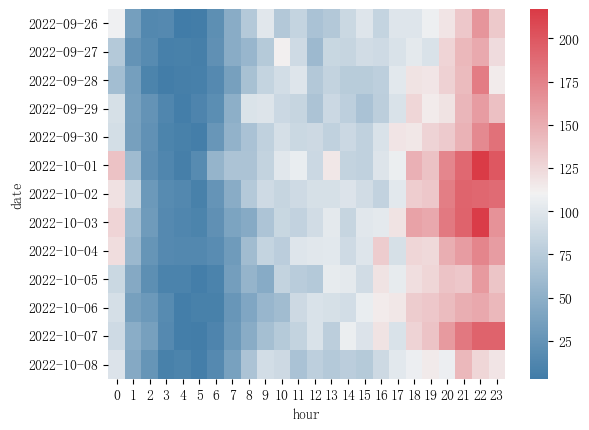

In [14]:
#fig = sns.heatmap(df_hourTB,cmap='viridis')
fig = sns.heatmap(df_hourTB, cmap=cmaps)
figure = fig.get_figure()
figure.savefig('fig/热力图2.png', dpi=200, bbox_inches='tight')

* 可以看出微博签到时间主要集中在每天的20:00-24:00，且在10月2日前后有明显增加


## 空间特征

In [15]:
df_loc = pd.read_csv('data/weibo_loc.csv')  # 坐标
df = df_origin.merge(df_loc, on='id', how='left')  # 坐标链接

In [16]:
df.head()

,id,userid,message,ts_created,date,poiid,lat,lon
0,4817910549973967,6339251717,记录一下合肥一日游[送花花][送花花],2022-09-26 11:27:30,2022-09-26,B2094651D16FAAF44693,31.866328,117.284086
1,4817738155690682,6080243764,真诚才是爱的秘密,2022-09-26 00:02:28,2022-09-26,B2094651D169A5FB439F,31.840678,117.171352
2,4819531555412098,5867909333,回家[给力],2022-09-30 22:48:48,2022-09-30,B2094251D564A2F5439A,31.854250,117.232044
3,4818048550179045,3289196050,躺平大师,2022-09-26 20:35:52,2022-09-26,B2094254D764A5FD469D,31.774587,117.337636
4,4819813207117305,6495662753,终于[泪],2022-10-01 17:27:59,2022-10-01,B2094450D46BA1F8459D,31.800856,117.284832


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26013 entries, 0 to 26012
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          26013 non-null  int64         
 1   userid      26013 non-null  int64         
 2   message     26013 non-null  object        
 3   ts_created  26013 non-null  datetime64[ns]
 4   date        26013 non-null  datetime64[ns]
 5   poiid       25978 non-null  object        
 6   lat         25975 non-null  float64       
 7   lon         25975 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 1.6+ MB


In [18]:
df.dropna(inplace=True)  # 删除空值

In [19]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=district.crs)  # 转shp

In [20]:
# 过滤不在合肥市的数据
gdf = gdf.clip(city).reset_index(drop=True)

<Axes: >

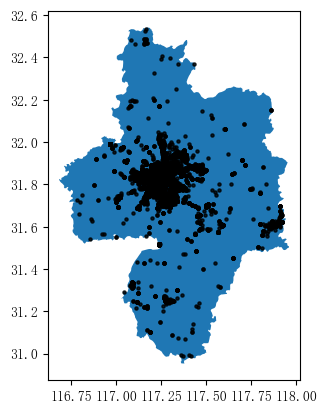

In [21]:
ax = city.plot()
gdf.plot(color='k', markersize=5, alpha=0.8, ax=ax)

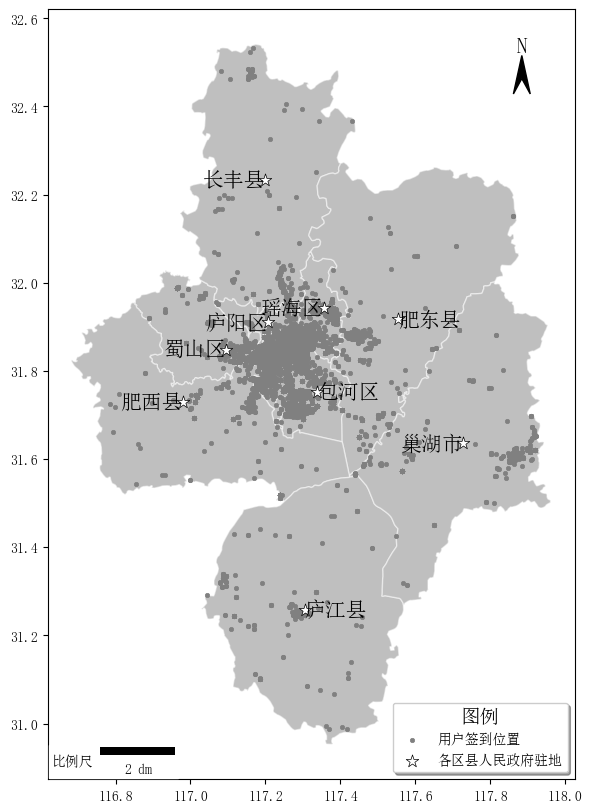

In [22]:
fig, ax = plt.subplots(figsize=(8,10))
bg = district.plot(ax=ax, facecolor='grey', edgecolor='white', alpha=0.5)
ax = gdf.plot(ax=bg, facecolor='grey', marker='o', markersize=10, linewidth=0.5, label='用户签到位置')
ax = district.representative_point().plot(ax=bg, facecolor='white', edgecolor='black', marker='*', markersize=90, linewidth=0.5, label='各区县人民政府驻地')

# 根据转换过投影的代表点，循环添加文字至地图上对应位置
for idx, _ in enumerate(district.representative_point()):
    # 提取单位名称
    region = district.loc[idx,'NAME']
    if (region=='包河区' or region=='肥东县' or region=='庐江县'): ax.text(_.x, _.y, region, ha="left", va="center", size=15)
    else: ax.text(_.x, _.y, region, ha="right", va="center", size=15)
    
# 指北针
def add_north(ax, labelsize=15, loc_x=0.9, loc_y=1.03, width=0.04, height=0.05, pad=0.14):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.4), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.4), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

# 比例尺位置和图层
scale1 = ScaleBar(
    dx=1, label='比例尺',
    location='lower left',  # in relation to the whole plot
    label_loc='left', scale_loc='bottom'  # in relation to the line
)
'''
# Color
scale2 = ScaleBar(
    dx=1, label='Scale 2', location='center',
    color='#b32400', box_color='yellow',
    box_alpha=0.8  # Slightly transparent box
)

# Font and text formatting
scale3 = ScaleBar(
    dx=1, label='Scale 3',
    font_properties={'family':'serif', 'size': 'large'},  # For more information, see the cell below
    scale_formatter=lambda value, unit: f'> {value} {unit} <'
)'''
# ax.axis('off') # 移除坐标轴
plt.rcParams['legend.title_fontsize'] = 14 # 单独提前设置图例标题大小
add_north(ax) # 加指北针
ax.add_artist(scale1) # 加比例尺
ax.legend(title="图例",loc='lower right',ncol=1,shadow=True) # 设置图例标题，位置，排列方式，是否带有阴影
fig.savefig('fig/签到总体分布.png', dpi=200) # 保存地图

In [23]:
# 计算各区县的签到数
district = district.merge(
    gdf.sjoin(district[['geometry','NAME']]).groupby('NAME').size().reset_index(name='count'),
    on='NAME',
    how='left'
)
district

,PAC,NAME,省代码,省,市代码,市,类型,geometry,count
0,340102,瑶海区,340000,安徽省,340100,合肥市,市辖区,"POLYGON ((117.32167 32.07037, 117.32165 32.069...",1123
1,340103,庐阳区,340000,安徽省,340100,合肥市,市辖区,"POLYGON ((117.10966 31.95955, 117.10981 31.959...",12884
2,340104,蜀山区,340000,安徽省,340100,合肥市,市辖区,"POLYGON ((116.93539 32.02786, 116.93592 32.026...",6388
3,340111,包河区,340000,安徽省,340100,合肥市,市辖区,"POLYGON ((117.31609 31.84567, 117.31649 31.845...",3377
4,340121,长丰县,340000,安徽省,340100,合肥市,县,"POLYGON ((117.18598 32.53923, 117.18947 32.537...",257
5,340122,肥东县,340000,安徽省,340100,合肥市,县,"POLYGON ((117.42015 32.25676, 117.41851 32.256...",421
6,340123,肥西县,340000,安徽省,340100,合肥市,县,"POLYGON ((117.24379 31.66752, 117.24401 31.665...",578
7,340124,庐江县,340000,安徽省,340100,合肥市,县,"POLYGON ((117.46937 31.53981, 117.47504 31.530...",284
8,340181,巢湖市,340000,安徽省,340100,合肥市,县级市,"POLYGON ((117.81105 31.99763, 117.81313 31.997...",589


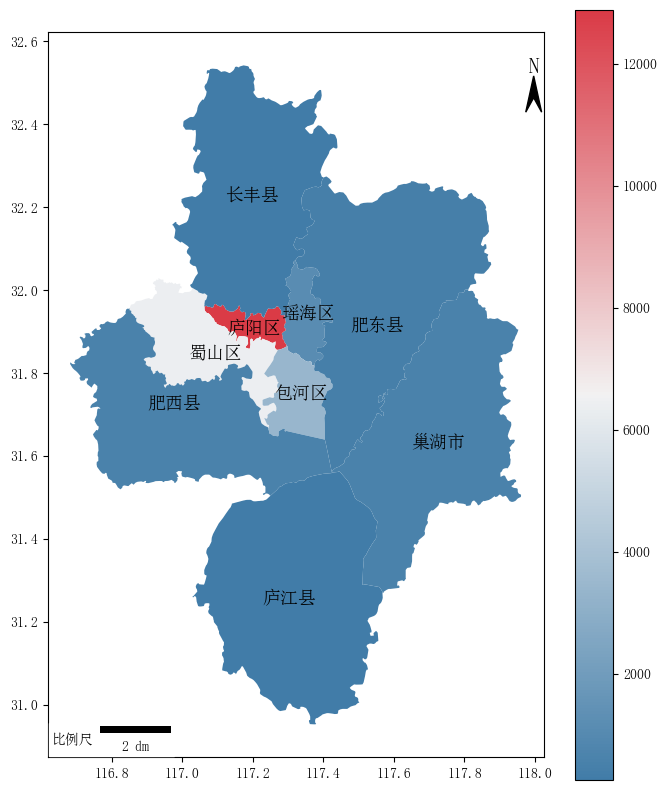

In [24]:
fig, ax = plt.subplots(figsize=(8,10))
ax = district.plot(ax=ax, column='count', cmap=cmaps, legend=True)

# 根据转换过投影的代表点，循环添加文字至地图上对应位置
for idx, _ in enumerate(district.representative_point()):
    # 提取单位名称
    region = district.loc[idx, 'NAME']
    ax.text(_.x, _.y, region, ha="center", va="center", size=13)

# 指北针
def add_north(ax, labelsize=15, loc_x=0.98, loc_y=1.03, width=0.04, height=0.05, pad=0.14):
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.4), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.4), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

# 比例尺位置和图层
scale1 = ScaleBar(
    dx=1, label='比例尺',
    location='lower left',  # in relation to the whole plot
    label_loc='left', scale_loc='bottom'  # in relation to the line
) 

# ax.axis('off') # 移除坐标轴
add_north(ax) # 加指北针
ax.add_artist(scale1) # 加比例尺
fig.savefig('fig/各区县签到分布.png', dpi=200) # 保存地图

* 签到点主要集中在庐阳区、蜀山区和包河区

# 城市情感结果分析

In [25]:
import re
import jieba

import numpy as np
from wordcloud import WordCloud
from PIL import Image

In [26]:
df_sa = pd.read_csv('data/weibo_pred.csv') # 情感
df = pd.merge(df, df_sa, on='id', how="left") # 情感-位置
df.dropna(inplace=True)

In [27]:
df

,id,userid,message,ts_created,date,poiid,lat,lon,sa,sa_prob
0,4817910549973967,6339251717,记录一下合肥一日游[送花花][送花花],2022-09-26 11:27:30,2022-09-26,B2094651D16FAAF44693,31.866328,117.284086,1,0.985861
1,4817738155690682,6080243764,真诚才是爱的秘密,2022-09-26 00:02:28,2022-09-26,B2094651D169A5FB439F,31.840678,117.171352,1,0.954281
2,4819531555412098,5867909333,回家[给力],2022-09-30 22:48:48,2022-09-30,B2094251D564A2F5439A,31.854250,117.232044,1,0.913072
3,4818048550179045,3289196050,躺平大师,2022-09-26 20:35:52,2022-09-26,B2094254D764A5FD469D,31.774587,117.337636,1,0.869380
4,4819813207117305,6495662753,终于[泪],2022-10-01 17:27:59,2022-10-01,B2094450D46BA1F8459D,31.800856,117.284832,1,0.681871
...,...,...,...,...,...,...,...,...,...,...
25970,4820530244883475,6219366090,热傻了今天,2022-10-03 16:57:14,2022-10-03,B2094452D265A0FA449E,31.774107,117.385628,-1,0.137644
25971,4821179631666949,6557015016,#挪威海底电缆断裂#北约除了干瞪眼！实在做不出别的事情 跟北溪二号一样 哑巴吃黄连，有苦...,2022-10-05 11:57:40,2022-10-05,8008634010000000000,31.863186,117.277521,-1,0.052503
25972,4821641589163051,5639007389,今天：合肥下雨了，晚上加班到十点半 不过还好，心情不是很糟糕 我还是心心念念想要养一只小猫,2022-10-06 18:33:19,2022-10-06,B2094651D16EAAFA429C,31.870802,117.276782,1,0.667659
25973,4818771782408232,2072019043,参观晚清重臣李鸿章故居，重温那段风云变幻的历史，不胜感慨！“时来天地皆同力，运去英雄不自由”...,2022-09-28 20:29:44,2022-09-28,B2094757D069A0F5499B,31.866294,117.285586,-1,0.489150


## 词云图

In [28]:
texts = list(df['message'].apply(lambda x: re.findall('[\u4e00-\u9fa5]+', x ,re.S)))  # 提取中文
texts = ["".join(text) for text in texts]  # 二维列表转一维 
text_cut = [jieba.lcut(text, cut_all=True) for text in texts if text !='']  # 分词
text_cut = [text for text1 in text_cut for text in text1]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\15499\AppData\Local\Temp\jieba.cache
Loading model cost 0.496 seconds.
Prefix dict has been built successfully.


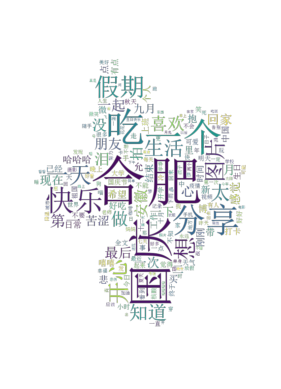

In [29]:
# 字体路径
font_path = ('Times_SimSun.ttf')
# 停词
with open('stopwords/中文停用词库.txt',encoding='utf-8') as f: #可根据需要打开停用词库，然后加上不想显示的词语
    con = f.readlines()
    stop_words = set()
    for i in con:
        i = i.replace("\n", "")  
        stop_words.add(i)
import collections # 词频统计库
object_list = []
for word in text_cut: # 循环读出每个分词
    if word not in stop_words and len(word)>0: # 如果不在去除词库中
        object_list.append(word) # 分词追加到列表
# 词频统计
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top10 = word_counts.most_common(100) # 获取前10最高频的词
# 生成对象
mask = np.array(Image.open('fig/合肥词云形状.png'))
wc = WordCloud(
    mask=mask,
    width=500,
    height=400,
    font_path=font_path,
    mode='RGBA',
    stopwords=stop_words,
    background_color=None
).generate_from_frequencies(word_counts)
# 显示词云
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
wc.to_file('fig/合肥词云图.png')

## 时间特征

In [30]:
df_sa1 = df[df['sa']==1]
df_sa2 = df[df['sa']==-1]

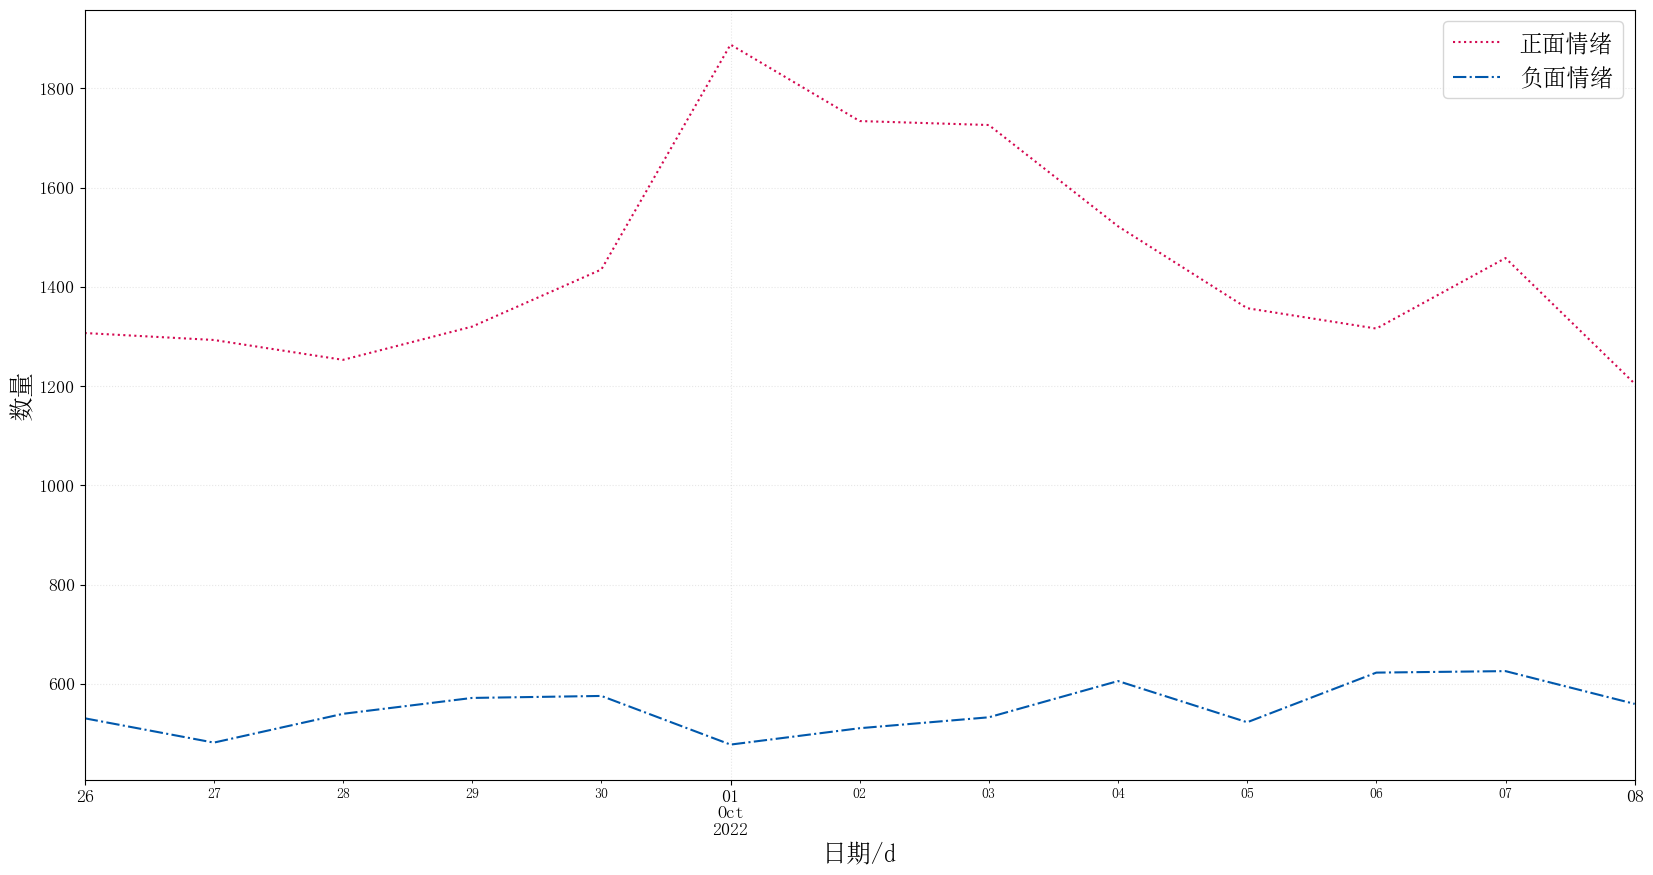

In [31]:
ax = df_sa1.set_index('ts_created').resample('D')['id'].count().plot(ls=':',label='正面情绪',color='#D40850')
df_sa2.set_index('ts_created').resample('D')['id'].count().plot(ax=ax,ls='-.',label='负面情绪',color='#0058AC',figsize=(20,10))
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('日期/d',size=18)
plt.ylabel('数量',size=18)
plt.grid(ls=':',alpha=0.3)
plt.legend(loc='best',prop={'size':17})

In [32]:
df.set_index(df['date'], inplace=True)
# df_locSa = df.sort_index()
df_1 = df.sort_index().loc['2022-10-01':'2022-10-07',:]
df_2 = df[~df['id'].isin(list(df_1.id))]

In [33]:
texts = list(df_1['message'].apply(lambda x: re.findall('[\u4e00-\u9fa5]+', x ,re.S)))  # 提取中文
texts = ["".join(text) for text in texts]  # 二维列表转一维 
text_cut = [jieba.lcut(text, cut_all=True) for text in texts if text !='']  # 分词
text_cut = [text for text1 in text_cut for text in text1]

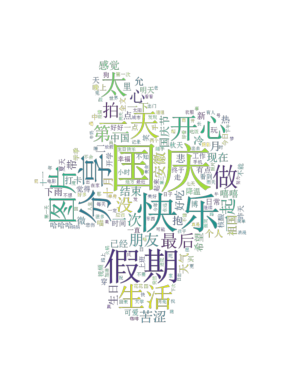

In [34]:
# 字体路径
font_path = ('Times_SimSun.ttf')
# 停词
with open('stopwords/中文停用词库-国庆.txt',encoding='utf-8') as f: #可根据需要打开停用词库，然后加上不想显示的词语
    con = f.readlines()
    stop_words = set()
    for i in con:
        i = i.replace("\n", "")  
        stop_words.add(i)
import collections # 词频统计库
object_list = []
for word in text_cut: # 循环读出每个分词
    if word not in stop_words and len(word)>0: # 如果不在去除词库中
        object_list.append(word) # 分词追加到列表
# 词频统计
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top10 = word_counts.most_common(100) # 获取前10最高频的词
# 生成对象
mask = np.array(Image.open('fig/合肥词云形状.png'))
wc = WordCloud(
    mask=mask,
    width=500,
    height=400,
    font_path=font_path,
    mode='RGBA',
    stopwords=stop_words,
    background_color=None
).generate_from_frequencies(word_counts)
# 显示词云
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
wc.to_file('fig/国庆词云图.png')

In [35]:
texts = list(df_2['message'].apply(lambda x: re.findall('[\u4e00-\u9fa5]+', x ,re.S)))  # 提取中文
texts = ["".join(text) for text in texts]  # 二维列表转一维 
text_cut = [jieba.lcut(text, cut_all=True) for text in texts if text !='']  # 分词
text_cut = [text for text1 in text_cut for text in text1]

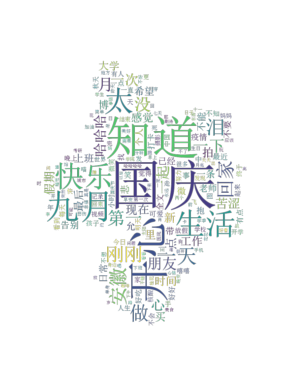

In [36]:
# 字体路径
font_path = ('Times_SimSun.ttf')
# 停词
with open('stopwords/中文停用词库-工作日.txt',encoding='utf-8') as f: #可根据需要打开停用词库，然后加上不想显示的词语
    con = f.readlines()
    stop_words = set()
    for i in con:
        i = i.replace("\n", "")  
        stop_words.add(i)
import collections # 词频统计库
object_list = []
for word in text_cut: # 循环读出每个分词
    if word not in stop_words and len(word)>0: # 如果不在去除词库中
        object_list.append(word) # 分词追加到列表
# 词频统计
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top10 = word_counts.most_common(100) # 获取前10最高频的词
# 生成对象
mask = np.array(Image.open('fig/合肥词云形状.png'))
wc = WordCloud(
    mask=mask,
    width=500,
    height=400,
    font_path=font_path,
    mode='RGBA',
    stopwords=stop_words,
    background_color=None
).generate_from_frequencies(word_counts)
# 显示词云
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
wc.to_file('fig/工作日词云图.png')

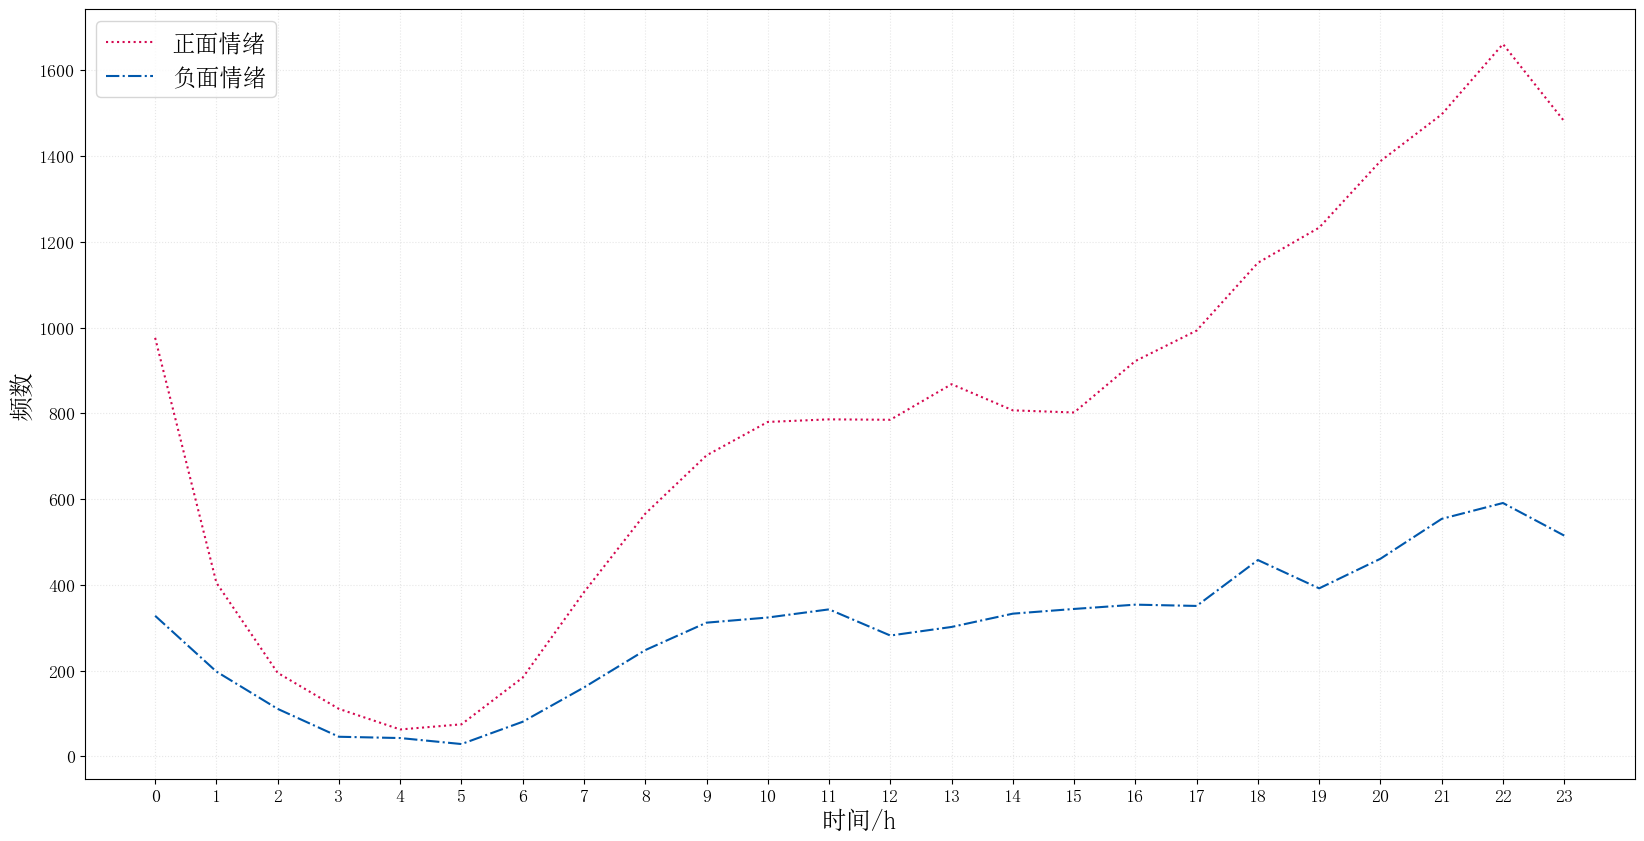

In [37]:
df['hour'] = df['ts_created'].dt.hour
df_sa1 = df[df['sa']==1]
df_sa2 = df[df['sa']==-1]
ax = df_sa1.groupby('hour').id.count().plot(ls=':',label='正面情绪',color='#D40850')
df_sa2.groupby('hour').id.count().plot(ax=ax,ls='-.',label='负面情绪',color='#0058AC',figsize=(20,10))
plt.xticks(np.arange(0,24,1),size=13)
plt.yticks(size=13)
plt.xlabel('时间/h',size=18)
plt.ylabel('频数',size=18)
plt.grid(ls=':',alpha=0.3)
plt.legend(loc='best',prop={'size':17})

Text(0.5, 1.0, '国庆期间(外环)和工作日(内环)的正负面情绪占比')

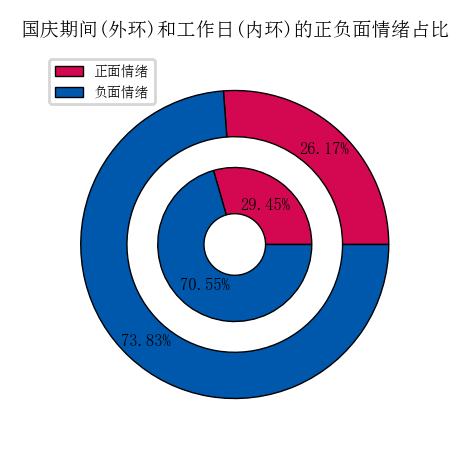

In [38]:
df = df.sort_index()
df_1 = df.loc['2022-10-01':'2022-10-07',:]
df_2 = pd.concat([df,df_1]).drop_duplicates(keep=False)
#with sns.axes_style('darkgrid'):
labels = ['正面情绪','负面情绪']
wedgeprops = {'width':0.3,'edgecolor':'black','linewidth':0.5}
colors = ['#D40850','#0058AC']
fig = plt.figure(figsize=(2.5,2.5),dpi=200)
plt.pie(df_1.groupby('sa').id.count().reset_index().id,
        radius=1,
        autopct="%.2f%%",
        textprops={"fontsize":6},
        pctdistance=0.85,
        wedgeprops=wedgeprops,
        startangle=0,
        colors=colors)
plt.pie(df_2.groupby('sa').id.count().reset_index().id,
        radius=0.5,
        autopct="%.2f%%",
        textprops={"fontsize":6},
        pctdistance=0.65,
        wedgeprops=wedgeprops,
        startangle=0,
        colors=colors)
plt.legend(labels,loc='upper left',prop={'size':5})
plt.title('国庆期间(外环)和工作日(内环)的正负面情绪占比',size=7)
#plt.text(0,0,'国庆期间',ha='center',va='center',fontsize=10)

## 空间特征

In [39]:
gdf_sa = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=city.crs) # 经纬度转点数据
gdf_sa = gdf_sa.clip(city)

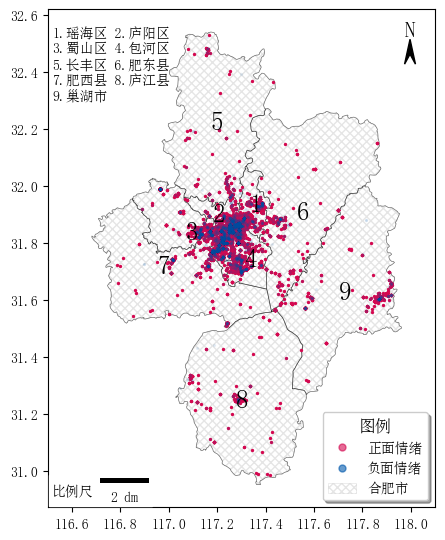

In [40]:
fig, ax = plt.subplots(figsize=(5,7))
# 绘图
bg = district.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)
bg = city.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.1, hatch='xxxx')
ax = gdf_sa[gdf_sa['sa']==1].plot(ax=bg, facecolor='#D40850', markersize=2, label='正面情绪')
ax = gdf_sa[gdf_sa['sa']==-1].plot(ax=bg, facecolor='#0058AC', markersize=2, label='负面情绪', alpha=0.07)

# 根据转换过投影的代表点，循环添加文字至地图上对应位置
for idx, _ in enumerate(district.representative_point()):
    # 提取单位名称
    region = idx+1
    ax.text(_.x,_.y,region,ha="center",va="center_baseline",size=18)

ax.text(116.52, 32.3,'1.瑶海区 2.庐阳区\n3.蜀山区 4.包河区\n5.长丰区 6.肥东县\n7.肥西县 8.庐江县\n9.巢湖市',fontsize=10)
    
# 设置图例
LegendElement = [
                 plt.plot([], [], marker='o', ms=5, ls='', mec=None, color='#D40850', alpha=0.6, label='正面情绪')[0],
                 plt.plot([], [], marker='o', ms=5, ls='', mec=None, color='#0058AC', alpha=0.6, label='负面情绪')[0],
                 mpatches.Patch(facecolor='none',
                                edgecolor='black',
                                linewidth=0.5,
                                alpha=0.1,
                                hatch='xxxx',
                                label='合肥市')
                ]
# 比例尺位置和图层
scale = ScaleBar(
                 dx=1, label='比例尺',
                 location='lower left',  # in relation to the whole plot
                 label_loc='left', scale_loc='bottom'  # in relation to the line
                ) 
# ax.axis('off') # 移除坐标轴
add_north(ax) # 加指北针
ax.add_artist(scale) # 加比例尺
ax.set_xlim(116.5,118.1)
plt.rcParams['legend.title_fontsize'] = 12 # 单独提前设置图例标题大小
ax.legend(title='图例',handles=LegendElement,loc='lower right',ncol=1,shadow=True,prop={'size':10})
fig.savefig('fig/情绪空间分布.png', dpi=200) # 保存

In [41]:
print(gdf_sa.groupby('sa').id.count().reset_index())
print(gdf_sa.groupby('sa').id.count().reset_index().loc[0,'id']/gdf_sa.id.count())
print(gdf_sa.groupby('sa').id.count().reset_index().loc[1,'id']/gdf_sa.id.count())

   sa     id
0  -1   7128
1   1  18773
0.27520172966294737
0.7247982703370526


In [42]:
gdf_sa = gdf_sa.sjoin(district[['geometry','NAME']]).drop(columns='index_right')

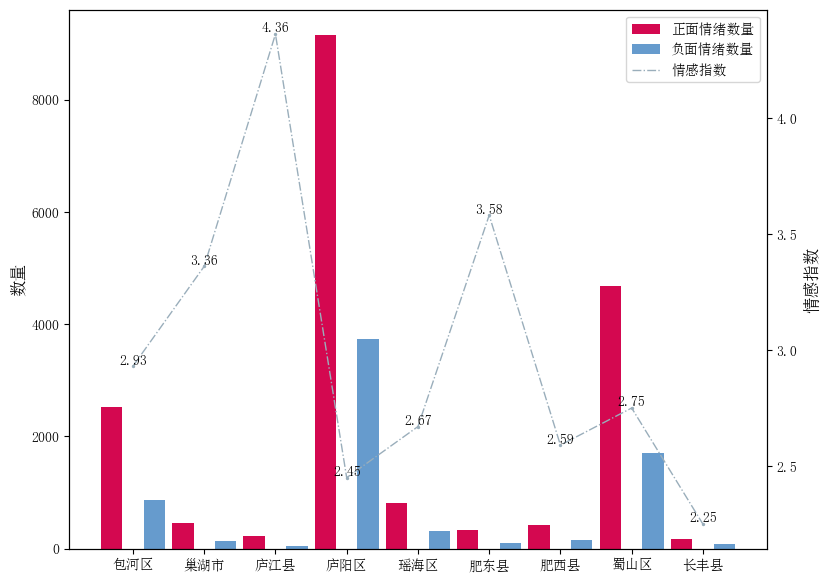

In [43]:
df0 = gdf_sa.groupby(['NAME','sa']).size().reset_index()
df0.columns = ['NAME','sa','count']
df_1 = df0[df0['sa']==1].reset_index(drop=True)
df_2 = df0[df0['sa']==-1].reset_index(drop=True)
#y1 = df_1['count']/(df_1['count']+df_2['count'])
#y2 = df_2['count']/(df_1['count']+df_2['count'])
#y1 = round(y1,2)
#y2 = round(y2,2)
y3 = df_1['count']/df_2['count']
y3 = round(y3,2)

fig, ax = plt.subplots(figsize=(9,7))
x = np.arange(len(df_1['NAME']))
width = 0.3 # 柱状图宽度
bar1 = ax.bar(x-width, df_1['count'], align='center', width=width, alpha=1, color='#D40850', label ='正面情绪数量')
bar2 = ax.bar(x+width, df_2['count'], align='center', width=width, alpha=0.6, color='#0058AC', label ='负面情绪数量')
ax.set_xticks(x)
ax.set_xticklabels(df_1['NAME'])
ax.set_ylabel('数量', size=12)
ax1 = ax.twinx() # 做镜像
#line1 = ax1.plot(x,y1,color='#F3432A',linestyle='--',linewidth=1,label ='正面情绪比例')
#line2 = ax1.plot(x,y2,color='#5FBBEA',linestyle='--',linewidth=1,label ='负面情绪比例')
line3 = ax1.plot(x, y3, color='#9AAEBB', linestyle='-.', linewidth=1, label ='情感指数')
ax1.set_ylabel('情感指数', size=12)
#scatter1 = plt.scatter(x,y1,color='#D40850',s=2)
#scatter2 = plt.scatter(x,y2,color='#0058AC',s=2)
scatter3 = plt.scatter(x, y3, color='#9AAEBB', s=2)

# 设置数字标签
for a,b in zip(x, y3):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)
'''for a, b, c in zip(x,y1,y2):
    plt.text(a,b,b,ha='center',va='bottom',fontsize=8)
    plt.text(a,c,c,ha='center',va='bottom',fontsize=8)'''

# 柱状图上方添加数据量标签
'''def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
              xy=(rect.get_x() + rect.get_width() / 2, height),
              xytext=(0, 3),  # 3 points vertical offset
              textcoords="offset points",
              ha='center', va='bottom'
              )
autolabel(bar1)
autolabel(bar2)'''

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes, prop={'size':10})
plt.show()
fig.savefig('fig/各区县正负情绪数量情感指数.png', dpi=300)